In [1]:
# Necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

In [2]:
# Load dataset
df = pd.read_csv("Final-Dataset.csv")

# Encoding categorical target (strength) [weak, moderate and strong = 0, 1 and 2]
label_encoder = LabelEncoder()
df['strength'] = label_encoder.fit_transform(df['strength'])

# Features and target
X = df.drop(['strength', 'password'], axis=1).values
y = df['strength'].values

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [3]:
# Split data into train + val (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train + val into train (70%) and val (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [4]:
# Convert data to torch tensors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device selected: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

Device selected: cuda


In [5]:
# Define the neural network model
class PasswordNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PasswordNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 7)
        self.hidden2 = nn.Linear(7, 7)
        self.hidden3 = nn.Linear(7, 5)
        self.output = nn.Linear(5, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = self.output(x)
        return x

In [6]:
# Initialize the model, loss function, and optimizer
model = PasswordNN(input_dim=X_train.shape[1], output_dim=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Store loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation pass
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        
        # Accuracy calculation
        _, predicted_train = torch.max(outputs, 1)
        train_accuracy = (predicted_train == y_train_tensor).sum().item() / y_train_tensor.size(0)
        
        _, predicted_val = torch.max(val_outputs, 1)
        val_accuracy = (predicted_val == y_val_tensor).sum().item() / y_val_tensor.size(0)
    
    # Store metrics for later plotting
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy*100:.2f}%, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy*100:.2f}%')


Epoch [5/1000], Loss: 1.0875, Train Accuracy: 36.76%, Val Loss: 1.0865, Val Accuracy: 36.87%
Epoch [10/1000], Loss: 1.0846, Train Accuracy: 36.76%, Val Loss: 1.0836, Val Accuracy: 36.87%
Epoch [15/1000], Loss: 1.0818, Train Accuracy: 36.76%, Val Loss: 1.0808, Val Accuracy: 36.87%
Epoch [20/1000], Loss: 1.0791, Train Accuracy: 36.76%, Val Loss: 1.0781, Val Accuracy: 36.87%
Epoch [25/1000], Loss: 1.0764, Train Accuracy: 36.76%, Val Loss: 1.0754, Val Accuracy: 36.87%
Epoch [30/1000], Loss: 1.0735, Train Accuracy: 36.76%, Val Loss: 1.0725, Val Accuracy: 36.87%
Epoch [35/1000], Loss: 1.0706, Train Accuracy: 36.76%, Val Loss: 1.0696, Val Accuracy: 36.87%
Epoch [40/1000], Loss: 1.0675, Train Accuracy: 36.76%, Val Loss: 1.0663, Val Accuracy: 36.86%
Epoch [45/1000], Loss: 1.0639, Train Accuracy: 36.76%, Val Loss: 1.0628, Val Accuracy: 36.86%
Epoch [50/1000], Loss: 1.0601, Train Accuracy: 36.76%, Val Loss: 1.0588, Val Accuracy: 36.86%
Epoch [55/1000], Loss: 1.0553, Train Accuracy: 36.76%, Val Lo

In [8]:
# Test loop
model.eval()
with torch.no_grad():
    # Forward pass on test set
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    
    # Accuracy calculation on test set
    _, predicted_test = torch.max(test_outputs, 1)
    test_accuracy = (predicted_test == y_test_tensor).sum().item() / y_test_tensor.size(0)
    
    # Store test metrics
    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy*100:.2f}%')

Test Loss: 0.0085, Test Accuracy: 99.90%


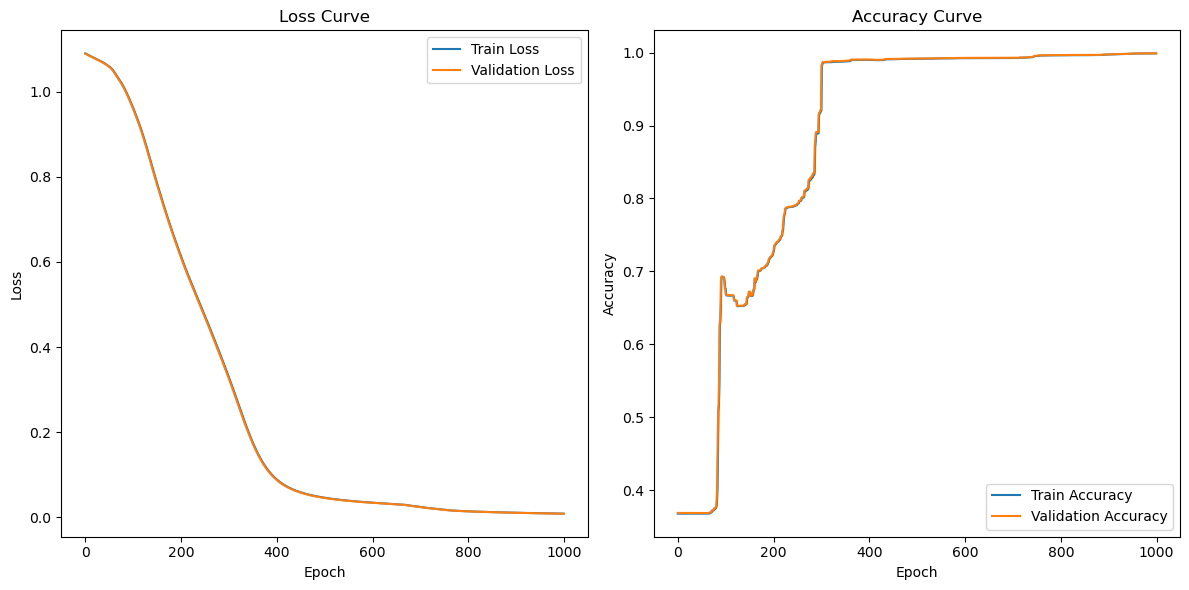

In [9]:
# Plot loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()


In [10]:
# Save the model's state_dict (parameters)
torch.save(model.state_dict(), "PasswordNN.pth")
print("Model saved successfully.")

# Save the fitted scaler
import joblib
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved successfully.")


Model saved successfully.
Scaler saved successfully.


In [ ]:
# If you want to load the trained model directly - uncomment the following code

# model = PasswordNN(input_dim=X_train.shape[1], output_dim=3)
# model.load_state_dict(torch.load("PasswordNN.pth"))
# model.eval()
# print("Model loaded successfully.")
